# Showing the endpoints of single stars for differen Z and M ZAMS

re-scaling the y-axis to represent a Salpeter IMF

In [42]:
import h5py as h5
import pandas as pd
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from astropy.table import Table

# from matplotlib.colors import LogNorm
# from scipy.ndimage.filters import gaussian_filter
# import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter

######################################
## PLOT setttings
plt.rc('font', family='serif')
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30, 18,20,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)     # legend fontsize


#################################################################
##   Parameters to set
#################################################################
sim_name        = "OldWinds_RemFryer2012"#"OldWinds_RemFryer2012" # sim_name determines which flags to run COMPAS with
root_out_dir    = f"/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/{sim_name}"


# Convey constant weight in IMF

I'm trying to represent the y-axis relative to the IMF weights. 
Assuming that the IMF follows the powerlaw: 

\begin{equation}
PDF = m^{-\alpha} 
\end{equation}

For a Salpeter IMF, we use $\alpha = 2.3$
then the CDF

\begin{equation}
CDF = \int_{-inf}^{x} m^{-2.3} dm  = \frac{-1}{1.3} x^{-1.3}
\end{equation}


The probability for some value to be in a bin is $CDF(y_i + \Delta y) - CDF(y_i)$ <br>
I'm tring to solve when this will be constant. I.e., I'm looking for a function of $\Delta y$ such that 

\begin{equation}
 CDF(y_i + \Delta y) - CDF(y_i)  = const 
\end{equation}

writing this out we get

\begin{equation}
 \frac{-1}{\alpha - 1} \Biggl( y_i + \Delta y \Biggr) ^{-\alpha + 1} + \frac{1}{\alpha - 1} y_i^{-\alpha + 1} = const 
\end{equation}

or again with $\alpha = 2.3$ 

\begin{equation}
 \frac{-1}{1.3} \Biggl( y_i + \Delta y \Biggr) ^{-1.3} + \frac{1}{1.3} y_i^{-1.3} = c 
\end{equation}

Solving this for $\Delta y$ we get:

\begin{equation}
\boxed{
 \Delta y = \Biggl( y^{(1-\alpha)} - c * (\alpha-1) \Biggr)^{1/(1-\alpha)}  - y
}
\end{equation}



In [79]:
# Equation to determine the delta_y needed to get a constant CDF
def delta_y(y, a = 2.3, c = 1e-3):
    """
    y: y value to start from
    Assuming a powerlaw: x**-a
    a: power law index 
    c: constant CDF difference, 
    e.g., how 'probable' you want your bin step to be
    """
    return (y**(1-a) - c * (a-1) )**(1/(1-a))  - y

    
# Bottom value of your y array
y_start = 5
const   = 1e-4 #5e-3

# Itteratively calculate the y values
Y_ticks = [y_start]
y = y_start
while y < 200: 
    dy = delta_y(y, a = 2.3, c = const) 
    print('y', y, 'dy', dy, 'y+dy', y+dy)
    y += dy
    Y_ticks.append(y)
    
print('Y_ticks', len(Y_ticks) , Y_ticks,  )

print('constant CDF? ', np.unique(-1/1.3 * np.array([Y_ticks[i]**-1.3 - Y_ticks[i+1]**-1.3 for i in range(len(Y_ticks)-1)]) ))



y 5 dy 0.004055420800503029 y+dy 5.004055420800503
y 5.004055420800503 dy 0.004062994147493448 y+dy 5.0081184149479965
y 5.0081184149479965 dy 0.004070589654654455 y+dy 5.012189004602651
y 5.012189004602651 dy 0.004078207410338486 y+dy 5.016267212012989
y 5.016267212012989 dy 0.00408584750334029 y+dy 5.02035305951633
y 5.02035305951633 dy 0.004093510022908475 y+dy 5.024446569539238
y 5.024446569539238 dy 0.004101195058739293 y+dy 5.0285477645979775
y 5.0285477645979775 dy 0.004108902700984629 y+dy 5.032656667298962
y 5.032656667298962 dy 0.004116633040253781 y+dy 5.036773300339216
y 5.036773300339216 dy 0.004124386167617011 y+dy 5.040897686506833
y 5.040897686506833 dy 0.004132162174606435 y+dy 5.045029848681439
y 5.045029848681439 dy 0.004139961153217797 y+dy 5.049169809834657
y 5.049169809834657 dy 0.004147783195919352 y+dy 5.0533175930305765
y 5.0533175930305765 dy 0.004155628395649202 y+dy 5.057473221426226
y 5.057473221426226 dy 0.004163496845818848 y+dy 5.0616367182720445
y 5.061

# Read the grid of single stars

In [80]:
keys_of_interest = ['Metallicity@ZAMS(1)', 'Mass@ZAMS(1)','Stellar_Type(1)']
ALL_SYS = pd.DataFrame()

# For each mass, compute the values and append them to the lists
for mass in [10, 20, 30, 40, 50, 60, 70,90, 100, 150]:
    print('mass', mass)

    loc = f'{root_out_dir}/SingleStarGrids/SingleStars_M{mass}/'

    # Read summary HDF5 datasets as pandas dataframes
    with h5.File(f'{loc}/COMPAS_Output.h5', 'r') as All_data:
        SYS = pd.DataFrame()
        for key in keys_of_interest:
            SYS[key] = All_data['BSE_System_Parameters'][key][()]

    # Append the data to the ALL_SYS dataframe
    ALL_SYS = pd.concat([ALL_SYS, SYS], ignore_index=True)

display(SYS)
# print(list(SYS.keys))
# detailed_data = f'{loc}/Detailed_Output/BSE_Detailed_Output_{i}.h5'
# detailh5 = h5.File(detailed_data, 'r')



mass 10
mass 20
mass 30
mass 40
mass 50
mass 60
mass 70
mass 90
mass 100
mass 150


,Metallicity@ZAMS(1),Mass@ZAMS(1),Stellar_Type(1)
0,0.000100,150.0,15
1,0.000106,150.0,15
2,0.000112,150.0,15
3,0.000119,150.0,15
4,0.000126,150.0,15
...,...,...,...
95,0.023825,150.0,14
96,0.025238,150.0,14
97,0.026735,150.0,14
98,0.028320,150.0,14


In [81]:
# # Mapping types to names 
# Stellar_Type_table = Table()
# Stellar_Type_table['types'] = ['MS_low', 'MS' ,'HG', 'AGB', 'CHeB', 'EAGB','TPAGB','HeMS','HeHG','HeGB','HeWD','COWD','ONeWD','NS','BH','massless remnant']
# Stellar_Type_table['indices'] = np.arange(len(Stellar_Type_table))

Stellar_Type_table = Table()
Stellar_Type_table['types'] = ['HeWD','COWD','ONeWD','NS','BH','massless remnant']
Stellar_Type_table['indices'] = np.arange(10, 16)


# Now let's scale our y axis

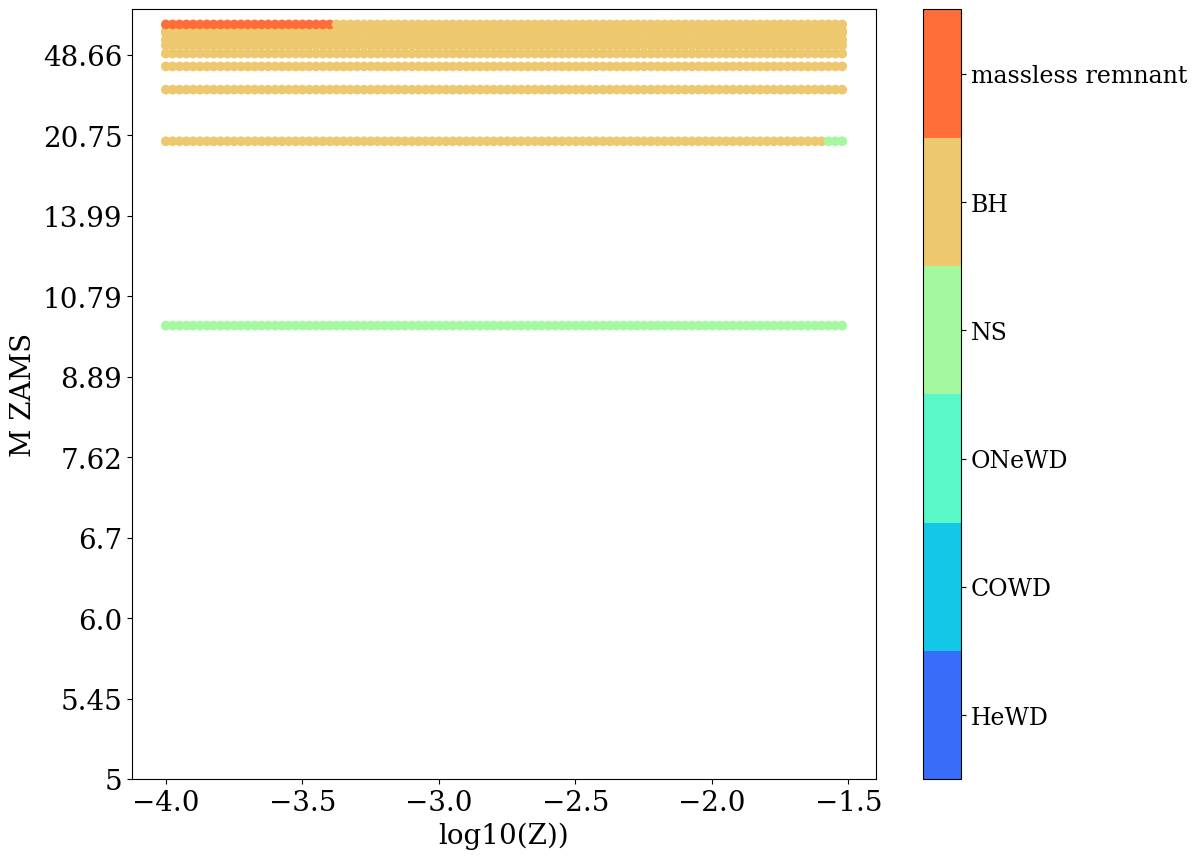

In [82]:
##########################
# START PLOTTING
##########################
fig, ax = plt.subplots(figsize=(12, 10))

# First define new y values
new_Y_ticks = np.linspace(0, 1, len(Y_ticks))

#######
qzams = np.linspace(0.1, 1, 100)
Min_MBH1 = 1e-3 * qzams**2.3


# Make cmap for stellar types
col_map_table = Stellar_Type_table
newcmp = ListedColormap(sns.color_palette("rainbow", len(col_map_table))) 

# map your old y values to the new y values using np.interp
im = ax.scatter(np.log10(ALL_SYS['Metallicity@ZAMS(1)']), np.interp(ALL_SYS['Mass@ZAMS(1)'], Y_ticks, new_Y_ticks), 
                c = ALL_SYS['Stellar_Type(1)'], cmap = newcmp,  marker = 'o', 
                vmin = min(col_map_table['indices']) -0.5, vmax= max(col_map_table['indices']) + 0.5)

# Create the colorbar
cb = plt.colorbar(im, ticks=col_map_table['indices'])
cb.ax.set_yticklabels(col_map_table['types'], size = 17)

# Set the y-ticks and y-ticklabels
# ax.set_yticks(new_Y_ticks)
ax.set_yticks(new_Y_ticks[::100], )
ax.yaxis.set_ticklabels([np.round(y,2) for y in Y_ticks[::100]]) # change the ticks' names to y
# ax.set_ylim(new_Y_ticks[0], new_Y_ticks[-1])

#######
ax.set_xlabel('log10(Z))')
ax.set_ylabel('M ZAMS')

# ax.set_xlim(0,1.1)
for mass in [10, 20, 30, 40, 50, 60, 70,90, 100, 150]:

plt.show()